# Step 0.1: GeoSpatial Infrastructure

Our project requires aggregating measurements to the neighborhood level, so it's important to have a robust geospatial infrastructure.

This notebook preprocesses cartographic boundary files of both census tracts and neighborhoods, for the top 8 US states we selected based on exploratoray analysis we did earlier. The same process was reproduced in notebook `0.1_Clean_Yelp: Data Pruning`.

## Definition

- **Census Tracts**: a relatively homogeneous geographical unit with respect to population characteristics, as delineated by the Census Bureau. Census data are only available at this level.
- **Neighborhoods**: cities, sometimes even different agencies within a city, have different methods for neighborhood delineation. Yelp has a neighborhood name designated to some businesses, but only a small fraction of the whole dataset. Zillow has composed a [dataset](https://www.zillow.com/howto/api/neighborhood-boundaries.htm) of neighborhood boundaries for all the largest U.S. cities. We use this dataset to map census tracts to neighborhood, then aggregate census variables to this level.

## Dependencies

It requires following packages to process geospatial data: [geopandas](http://geopandas.org/install.html), [rtree](http://toblerity.org/rtree/index.html).

You may need to run following commands in order to successfully install the dependencies:

```bash
brew install spatialindex 
pip install geopandas rtree
```

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 4)

sns.set(
    style="white",
    color_codes=True,
    rc={
        'axes.linewidth': 0.5,
        'lines.linewidth': 2,
        'axes.labelsize': 14,
        'axes.titlesize': 14
    }
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Neighborhood boundaries by Zillow

### Load data

The dataset was downloaded here: https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [2]:
import os

def read_shapefiles(folder):
    """Read all shape files under a folder and merge them"""
    shapes = [
        gpd.read_file(f"{folder}/{path}")
        for path in os.listdir(folder)
        if os.path.isdir(f"{folder}/{path}")
    ]
    return gpd.GeoDataFrame(pd.concat(shapes), crs=shapes[0].crs)

nbh = read_shapefiles('../data/step0/zillow-neighborhoods')

In [3]:
print('CRS:', nbh.crs)
print('Sape:', nbh.shape)

CRS: {'init': 'epsg:4269'}
Sape: (3369, 6)


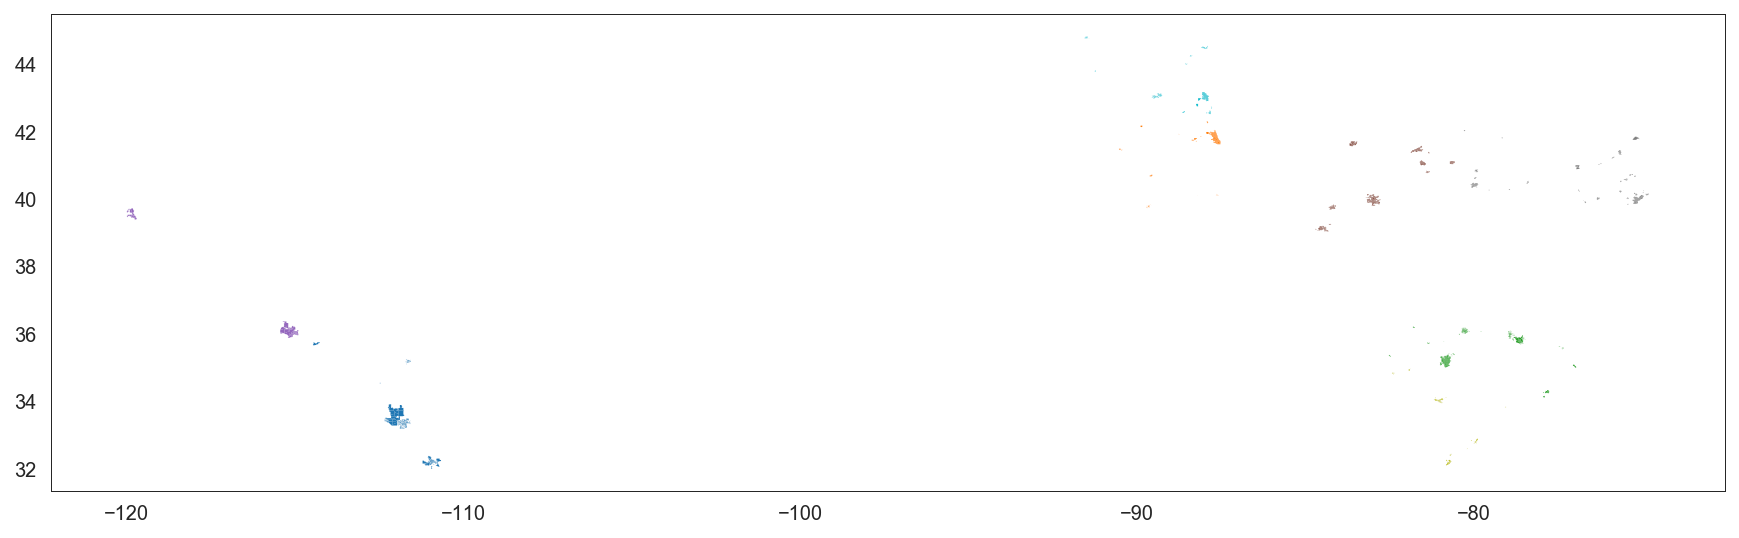

In [4]:
# We merged all neighborhoods into one
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'aspect':'equal'})
nbh.plot(column='State', ax=ax)

We calculates the areas of each neighborhoods, so to compute business density later. We use the [Equal Area Cylindrical]( http://proj4.org/projections/cea.html) projection to obtain the areas in square meters.

In [5]:
# nbh_areas = nbh.groupby('Nhood').agg({'Nhood_area': ['sum']}).sort_values(('Nhood_area','sum'), ascending=False)
nbh['Nhood'] = nbh['Name'] + ', ' + nbh['City'] + ', ' + nbh['State']
nbh['Nhood_area'] = nbh.to_crs({'proj':'cea'}).area
nbh

,State,County,City,Name,RegionID,geometry,Nhood,Nhood_area
0,AZ,Maricopa,Gilbert,Highland,256336,POLYGON ((-111.7123999999999 33.29793137600003...,"Highland, Gilbert, AZ",8.580705e+04
1,AZ,Maricopa,Gilbert,College Park,273316,"POLYGON ((-111.783694615 33.35004000000012, -1...","College Park, Gilbert, AZ",8.007886e+04
...,...,...,...,...,...,...,...,...
466,WI,Kenosha,Kenosha,Villa Capri,764272,POLYGON ((-87.82745554799999 42.62413872500008...,"Villa Capri, Kenosha, WI",1.356018e+06
467,WI,Kenosha,Kenosha,White Caps,764279,"POLYGON ((-87.914278 42.575636, -87.91419 42.5...","White Caps, Kenosha, WI",1.975782e+06


In [6]:
nbh_area_total = nbh.groupby('Nhood').agg({'Nhood_area': ['sum']})
nbh_area_total = nbh_area_total.sort_values(('Nhood_area', 'sum'), ascending=False)
nbh_area_total = pd.DataFrame(nbh_area_total.to_records())
nbh_area_total.columns = ['Nhood', 'Nhood_area_total']
nbh_area_total

,Nhood,Nhood_area_total
0,"North Scottsdale, Scottsdale, AZ",2.707229e+08
1,"Desert View, Phoenix, AZ",1.658504e+08
...,...,...
3351,"Westview Meadows Condominum, Madison, WI",7.589671e+03
3352,"Parkside Resident, Madison, WI",3.314451e+03


In [7]:
nbh2 = nbh.merge(nbh_area_total, on='Nhood')
nbh2

,State,County,City,Name,RegionID,geometry,Nhood,Nhood_area,Nhood_area_total
0,AZ,Maricopa,Gilbert,Highland,256336,POLYGON ((-111.7123999999999 33.29793137600003...,"Highland, Gilbert, AZ",8.580705e+04,8.580705e+04
1,AZ,Maricopa,Gilbert,College Park,273316,"POLYGON ((-111.783694615 33.35004000000012, -1...","College Park, Gilbert, AZ",8.007886e+04,8.007886e+04
...,...,...,...,...,...,...,...,...,...
3367,WI,Kenosha,Kenosha,Villa Capri,764272,POLYGON ((-87.82745554799999 42.62413872500008...,"Villa Capri, Kenosha, WI",1.356018e+06,1.356018e+06
3368,WI,Kenosha,Kenosha,White Caps,764279,"POLYGON ((-87.914278 42.575636, -87.91419 42.5...","White Caps, Kenosha, WI",1.975782e+06,1.975782e+06


There are 3353 unique neighborhoods, but not all of them have businesses. The size of `nbh_areas` and `nbh` does not match, because some neighborhood may have disjoint areas.

### Save processed data

Save the shapefile for all neighborhoods combined, and a CSV file for the total area of neighborhoods.

In [8]:
import fiona
fiona.supported_drivers

{'ARCGEN': 'r',
 'AeronavFAA': 'r',
 'BNA': 'raw',
 'DGN': 'raw',
 'DXF': 'raw',
 'ESRI Shapefile': 'raw',
 'GPKG': 'rw',
 'GPSTrackMaker': 'raw',
 'GPX': 'raw',
 'GeoJSON': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'OpenFileGDB': 'r',
 'PCIDSK': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [9]:
nbh.to_file('../data/step0/zillow-neighborhoods-all')

## Census Tracts

Let's do the same for census tracts.

The dataset was downloaded here: https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html

In [10]:
# State Abbr to FIPS_ID
# AZ NV NC PA OH WI IL SC
# 04 32 37 42 39 55 17 45
tract_raw = read_shapefiles('../data/step0/census-tracts')
tract_raw

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,04,019,004505,1400000US04019004505,04019004505,45.05,CT,1913435,0,"POLYGON ((-110.999209 32.27947, -110.999093 32..."
1,04,019,004511,1400000US04019004511,04019004511,45.11,CT,1613445,0,"POLYGON ((-110.978058 32.282815, -110.96107 32..."
...,...,...,...,...,...,...,...,...,...,...
1393,55,067,960400,1400000US55067960400,55067960400,9604,CT,344773704,3424381,"POLYGON ((-89.224284 45.111695, -89.2166189999..."
1394,55,078,940101,1400000US55078940101,55078940101,9401.01,CT,59550643,484128,"POLYGON ((-88.735591 44.921653, -88.735452 44...."


In [11]:
# Confirm that all geometry are of unique census tract
(tract_raw['STATEFP'] + tract_raw['COUNTYFP'] + tract_raw['TRACTCE']).unique().size

16189

In [12]:
# drop useless columns
tract = (
    tract_raw.drop(['AFFGEOID', 'NAME', 'TRACTCE','LSAD'], axis=1)
    .rename(columns={
        'GEOID': 'CT_ID',
        'ALAND': 'CT_LAND',
        'AWATER': 'CT_WATER',
    })
)
tract.to_file('../data/step0/census-tracts-all')

### Boundary Overlays

The boundaries of census tracts and neighborhoods do not align well. For example, there are some holes in the middle of the neighborhood boundaries for Last Vegas, but such holes do not exists in the census tracts. This is due to some [legal battles](https://www.reviewjournal.com/local/local-las-vegas/las-vegas-county-clash-over-annexation-moves/) in regard to annexations of new parcels while the city grows. The administrative boundaries of the city must abide to such limitations, but census tracts do not have to.

We can plot these differences on a map.

In [13]:
from shapely.geometry import Polygon

vegas_nbh = nbh[nbh['City'] == 'Las Vegas']
nv_tract = tract[tract['STATEFP'] == '32']  # filter by State: Nevada

vegas = gpd.overlay(vegas_nbh, nv_tract, how='intersection')

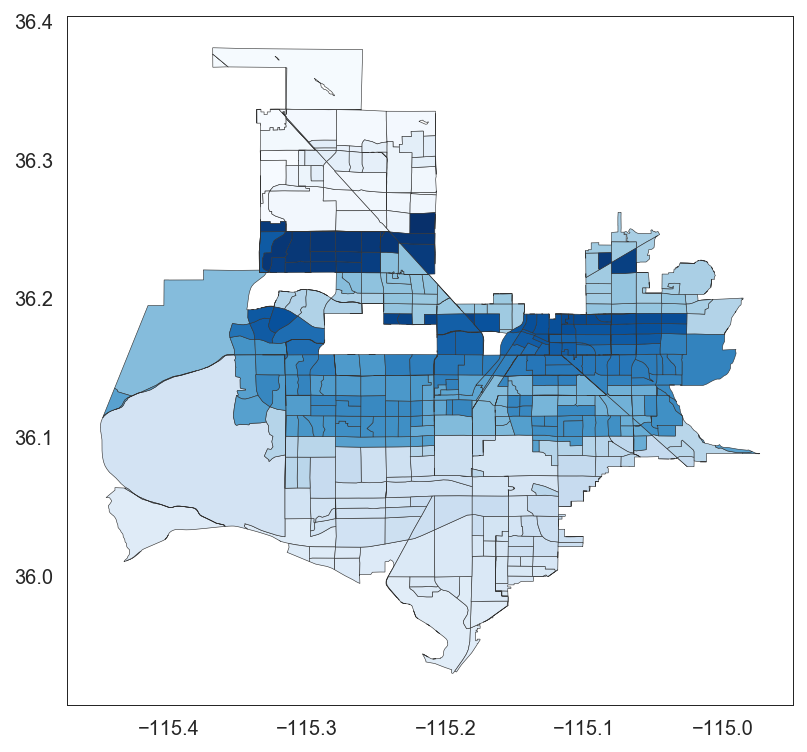

In [14]:
fig, ax = plt.subplots(
    figsize=(6.5,6.5),
    subplot_kw={
        'aspect':'equal'
    }
)
vegas.plot(cmap='Blues', edgecolor='#333333', ax=ax)

In [15]:
bounds = vegas_nbh.total_bounds
vegas_box = gpd.GeoDataFrame({
    'geometry': 
        [Polygon([[bounds[0], bounds[1]], [bounds[0], bounds[3]],
                  [bounds[2], bounds[3]], [bounds[2], bounds[1]],])]
})
vegas_tract = gpd.overlay(nv_tract, vegas_box, how='intersection')

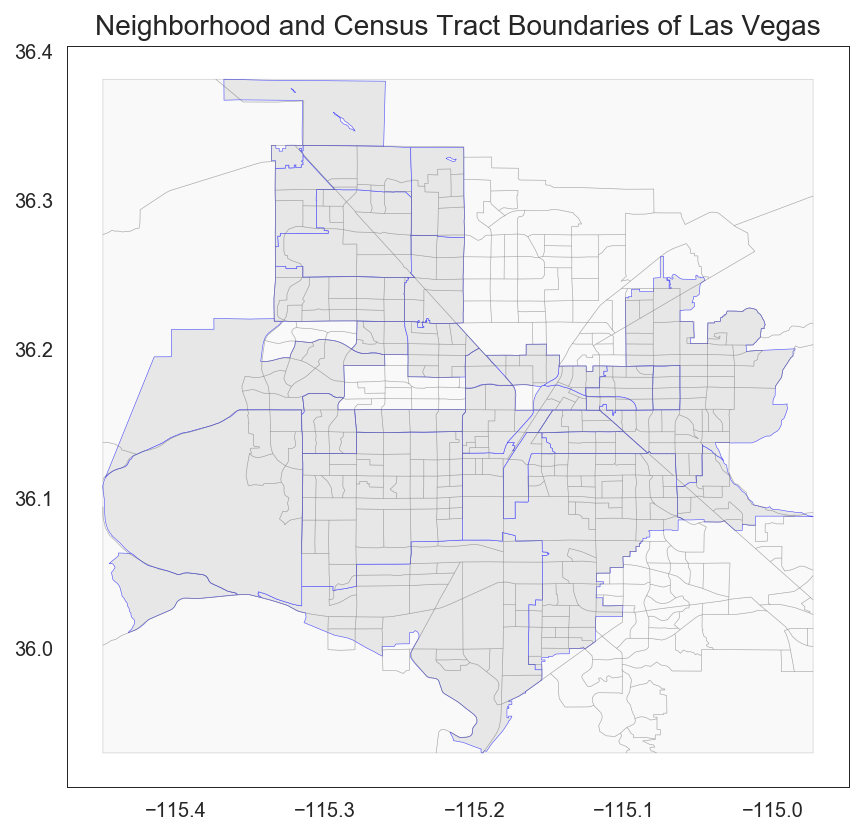

In [16]:
fig, ax = plt.subplots(
    figsize=(7,7),
    subplot_kw={
        'aspect':'equal'
    }
)
g1 = vegas_nbh.plot(color='#e3e3e3', edgecolor='blue', ax=ax)
g2 = vegas_tract.plot(color='#f0f0f0', edgecolor='#666666', ax=ax, alpha=0.35)
g1.set_title('Neighborhood and Census Tract Boundaries of Las Vegas')

In the above map, larger polygons in the foregound are the neighborhoods of Las Vegas; those in the background are the census tracts.

### Calculate overlap ratio

To obtain demographic information for neighborhoods, it is possible to calculate how much does each census tract lie in each neighborhoods, then use certain algorithm to proportionally allocate population in overlaying census tracts to neighborhoods.

In [18]:
import pandas as pd

def nbh_ct_merge(nbh, ct):
    
    # the intersection of every neighborhood and census tracts
    itc = gpd.overlay(nbh, ct, how='intersection')
    
    itc.crs = nbh.crs
    itc.loc[:,'area'] = itc.to_crs({'proj':'cea'}).area
    tmp = itc.groupby(['Nhood', 'CT_ID']).agg({ 'area': ['sum'] })
    tmp = pd.DataFrame(tmp.to_records())
    tmp.columns = ('Nhood', 'CT_ID', 'area')

    ct.loc[:,'area'] = ct.to_crs({'proj':'cea'}).area
    tmp2 = ct.groupby('CT_ID').agg({ 'area': ['sum'] })
    tmp2 = pd.DataFrame(tmp2.to_records())
    tmp2.columns = ('CT_ID', 'ct_area_total')

    merged = pd.merge(tmp, tmp2)
    merged.loc[:,'ct_area_ratio'] = merged['area'] / merged['ct_area_total']
    merged = merged.sort_values(['CT_ID', 'ct_area_ratio'], ascending=[True, False])
    
    grouped = merged.groupby(['Nhood','CT_ID']).agg({
        'ct_area_ratio': 'first'
    })
    return merged, grouped


# This is really really slow...
# nbh_ct_merged, nbh_ct_grouped = nbh_ct_merge(nbh, tract_clean)

# A subset would be better...
nbh_ct_merged, nbh_ct_grouped = nbh_ct_merge(vegas_nbh, nv_tract)

display(nbh_ct_merged)
display(nbh_ct_grouped)

/Users/jesse/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Nhood,CT_ID,area,ct_area_total,ct_area_ratio
468,"Twin Lakes, Las Vegas, NV",32003000101,3.404891e+06,3.718033e+06,0.915777
469,"West Las Vegas, Las Vegas, NV",32003000101,2.723104e+05,3.718033e+06,0.073240
...,...,...,...,...,...
10,"Summerlin South, Las Vegas, NV",32003007500,3.573022e+04,1.769267e+09,0.000020
621,"Sunrise Manor, Las Vegas, NV",32003007800,1.566223e+06,1.385729e+08,0.011303


ct_area_ratio
Nhood                       CT_ID                     
Blue Diamond, Las Vegas, NV 32003005827       0.000026
                            32003005840       0.000947
...                                                ...
Winchester, Las Vegas, NV   32003002303       0.000134
                            32003002501       0.000242

[640 rows x 1 columns]

For now, this seems like an overkill.